# Finding the parameters of a normal distribution

In this tutorial we will use black-it to find the mean and variance of a normal distribution by fitting the 'model' to a dataset. 
Obviously the parameters of a normal distribution can be obtained more efficiently (such as a by maximum likelihood), yet this example can be useful to understand how black-it works in practice.

In [1]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

We stard by loading the dataset that we want to fit with our model.

In [2]:
# load a dataset

true_params = [1, 1]  # in general these are not known!
real_data = np.atleast_2d(np.loadtxt(f"data/gaussian_mean{true_params[0]}_var{true_params[1]}.txt")).T

Text(0, 0.5, 'value')

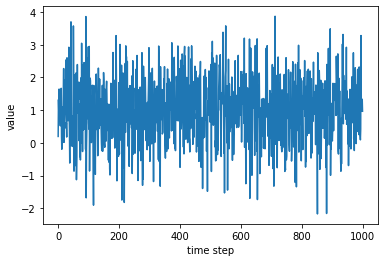

In [3]:
plt.plot(real_data[:, 0])
plt.xlabel("time step")
plt.ylabel("value")

## Initialize a calibrator object

Then, to set up a calibration one needs to define the following components first:

1. a _model_ to be calibrated 
2. a _loss function_ to measure the distance between the real time series and the simulated time series
3. a set of _samplers_ that iteratively suggest a set of parameter values to explore
4. the _parameter space_ that should be explored

#### 1 Model simulator

In [4]:
# a normal distribution with unknown mean and variance
from models.simple_models import NormalMV

In [5]:
# when called with a set of parameter values, the model provides a simulated time series
NormalMV([1, 1], N=10, seed=0)

array([[2.76405235],
       [1.40015721],
       [1.97873798],
       [3.2408932 ],
       [2.86755799],
       [0.02272212],
       [1.95008842],
       [0.84864279],
       [0.89678115],
       [1.4105985 ]])

#### 2 Loss function 

In [6]:
# loss function based on the Method Of Moments
from black_it.loss_functions.msm import MethodOfMomentsLoss

loss = MethodOfMomentsLoss()

#### 3 Samplers

In [7]:
# import some samplers
from black_it.samplers.best_batch import BestBatchSampler
from black_it.samplers.halton import HaltonSampler
from black_it.samplers.r_sequence import RSequenceSampler
from black_it.samplers.random_forest import RandomForestSampler
from black_it.samplers.random_uniform import RandomUniformSampler

# initialize the samplers with their specific 'batch_size', i.e. the number of points
# explored every time they are called
batch_size = 4
random_sampler = RandomUniformSampler(batch_size=batch_size)
rseq_sampler = RSequenceSampler(batch_size=batch_size)
halton_sampler = HaltonSampler(batch_size=batch_size)
best_batch_sampler = BestBatchSampler(batch_size=batch_size)
random_forest_sampler = RandomForestSampler(batch_size=batch_size)

samplers = [
    random_sampler,
    rseq_sampler,
    halton_sampler,
    random_forest_sampler,
    best_batch_sampler,
]

#### 4) Parameter space (bounds and precision)

In [8]:
# the full space of parameters is defined by the lower and upper bounds
# and by the precision of each parameter
bounds = [[0.00, 0.01], [2.00, 2.00]]

precisions = [0.0001, 0.0001]

#### Finally, initialise a Calibrator object

In [9]:
from black_it.calibrator import Calibrator

# initialize a Calibrator object
cal = Calibrator(
    samplers=samplers,
    real_data=real_data,
    model=NormalMV,
    parameters_bounds=bounds,
    parameters_precision=precisions,
    ensemble_size=5,
    loss_function=loss,
    saving_folder=None,
)


***
Number of free params:       2.
Explorable param space size: 398039901.
***

Selecting 4 processes for the parallel evaluation of the model


## Calibration

In [10]:
params, losses = cal.calibrate(10)


BATCH NUMBER:   1
PARAMS SAMPLED: 0

METHOD: RandomUniformSampler
----> sim exec elapsed time: 1.7s
---->   min loss new params: 0.17
---->   avg loss new params: 1.41
----> avg loss exist params: 1.41
---->         curr min loss: 0.16632065926583173
====>    total elapsed time: 1.7s

METHOD: RSequenceSampler
----> sim exec elapsed time: 0.1s
---->   min loss new params: 1.6
---->   avg loss new params: 1.97
----> avg loss exist params: 1.69
---->         curr min loss: 0.16632065926583173
====>    total elapsed time: 0.1s

METHOD: HaltonSampler
----> sim exec elapsed time: 0.1s
---->   min loss new params: 0.77
---->   avg loss new params: 1.46
----> avg loss exist params: 1.61
---->         curr min loss: 0.16632065926583173
====>    total elapsed time: 0.2s

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.1s
---->   min loss new params: 0.64
---->   avg loss new params: 0.94
----> avg loss exist params: 1.45
---->         curr min loss: 0.16632065926583173
====>    total

----> sim exec elapsed time: 0.1s
---->   min loss new params: 0.43
---->   avg loss new params: 0.54
----> avg loss exist params: 1.27
---->         curr min loss: 0.09902649522714026
====>    total elapsed time: 1.9s

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.1s
---->   min loss new params: 0.29
---->   avg loss new params: 0.48
----> avg loss exist params: 1.24
---->         curr min loss: 0.09902649522714026
====>    total elapsed time: 0.1s

BATCH NUMBER:   8
PARAMS SAMPLED: 140

METHOD: RandomUniformSampler
----> sim exec elapsed time: 0.1s
---->   min loss new params: 1.54
---->   avg loss new params: 2.54
----> avg loss exist params: 1.28
---->         curr min loss: 0.09902649522714026
====>    total elapsed time: 0.1s

METHOD: RSequenceSampler
----> sim exec elapsed time: 0.1s
---->   min loss new params: 1.05
---->   avg loss new params: 1.86
----> avg loss exist params: 1.3
---->         curr min loss: 0.09902649522714026
====>    total elapsed time: 0.1s

MET

In [11]:
# best parameters obtained so far
params[0]

array([1.0002, 0.9791])

## Plots

In [12]:
# index of mimumum loss
idxmin = np.argmin(cal.losses_samp)
param_min = cal.params_samp[idxmin]

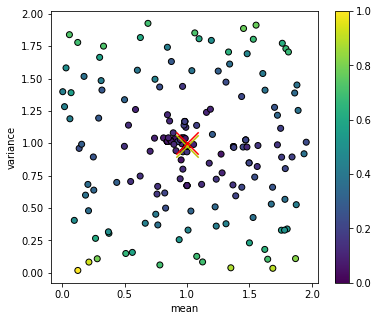

In [13]:
# scatter plot of losses
plt.figure(figsize=(6, 5))

plt.scatter(cal.params_samp[:, 0], cal.params_samp[:, 1], c=cal.losses_samp, edgecolor="k")

plt.scatter(param_min[0], param_min[1], marker="x", s=500, color="y")
plt.scatter(true_params[0], true_params[1], marker="x", s=500, color="red")


plt.xlabel("mean")
plt.ylabel("variance")
plt.colorbar()

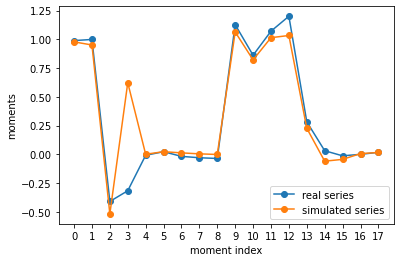

In [14]:
from black_it.utils.time_series import get_mom_ts

real_moments = get_mom_ts(cal.real_data)
simulated_moments = get_mom_ts(cal.series_samp[idxmin, 0, :, :])

# agreement of moments
plt.figure()
plt.plot(real_moments, "-o", label="real series")
plt.plot(simulated_moments, "-o", label="simulated series")
plt.xlabel("moment index")
plt.xticks(np.arange(18))
plt.ylabel("moments")
plt.legend()

In [15]:
# convergence

losses_per_batch = [cal.losses_samp[cal.batch_num_samp == i] for i in range(int(max(cal.batch_num_samp)) + 1)]
mins_per_batch = np.array([np.min(l) for l in losses_per_batch])
cummin_per_batch = [np.min(mins_per_batch[: i + 1]) for i in range(mins_per_batch.shape[0])]

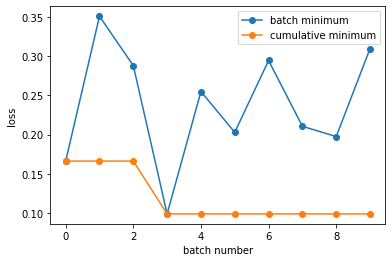

In [16]:
plt.figure()
plt.plot(mins_per_batch, "-o", label="batch minimum")
plt.plot(cummin_per_batch, "-o", label="cumulative minimum")
plt.ylabel("loss")
plt.xlabel("batch number")
plt.legend()